In [272]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LeakyReLU
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.optimizers import adam_v2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from datetime import datetime

# Preparar los datos
Preparamos los datos previa separación. Codificamos numéricamente y eliminamos columnas que no vamos a utilizar

In [273]:
df = pd.read_csv('Datasets/Data_Combinada.csv', low_memory=False)

Eliminamos columnas que no utilizaremos, como las coordenadas, o columnas repetidas como distrito con código distrito y lesividad con código lesividad

In [274]:
df.drop(columns=['distrito', 'coordenada_y_utm', 'coordenada_x_utm', 'localizacion', 'numero', 'lesividad'],
        inplace=True)

In [275]:
# # TODO Pruebas eficiencia modelo IA Dropeamos todos los que no son conductores y dropeamos la columna luego ya que es redundante
df.drop(df[df['tipo_persona'] != 'Conductor'].index, inplace=True)
df.pop('tipo_persona')

0        Conductor
1        Conductor
2        Conductor
4        Conductor
5        Conductor
           ...    
74955    Conductor
74957    Conductor
74958    Conductor
74959    Conductor
74960    Conductor
Name: tipo_persona, Length: 60493, dtype: object

In [276]:
df['sexo'].replace({'M': 0, 'H': 1}, inplace=True)

In [277]:
df['fugado'].replace({'No': 0, 'Si': 1}, inplace=True)

In [278]:
# df['tipo_persona'].replace({'Conductor': 3, 'Pasajero': 2, 'No': 1}, inplace=True)

In [279]:
# El criterio según la fuente de datos es que si es None es nada, de todas formas si fue ingresado debería existir registro
# por lo que es muy raro el caso contrario
df['cod_lesividad'].fillna(0, inplace=True)

In [280]:
def marca_de_clase_rango_edad(edad: str) -> float:
    regex_format = r'\b\d+\b'
    numbers = re.findall(regex_format, edad)
    if len(numbers) >= 2:
        return (int(numbers[0]) + int(numbers[1])) / 2

    # if edad == 'Menor de 5 años':
    #     return 5
    # 
    # if edad == 'Más de 74 años':
    #     return 74
    else:
        return -1


df['rango_edad'] = df['rango_edad'].apply(marca_de_clase_rango_edad)
df.rename(columns={'rango_edad': 'marca_de_clase_edad'}, inplace=True)

In [281]:
print(sorted(df['marca_de_clase_edad'].unique()))

[-1.0, 7.5, 12.0, 16.0, 19.0, 22.5, 27.0, 32.0, 37.0, 42.0, 47.0, 52.0, 57.0, 62.0, 67.0, 72.0]


In [282]:
def minutes_from_midnight(hour_str: str) -> int:
    clock = hour_str.split(':')
    minutes = 0

    minutes = int(clock[0]) * 60
    minutes = minutes + int(clock[1])

    return minutes


df['hora'] = df['hora'].apply(minutes_from_midnight)
df.pop('hora').head()

0     90
1     90
2     30
4     30
5    110
Name: hora, dtype: int64

In [283]:
def extract_day(date_str: str) -> int:
    date_parts = date_str.split('/')
    if len(date_parts) >= 3:
        return int(date_parts[0])


def extract_month(date_str: str) -> int:
    date_parts = date_str.split('/')
    if len(date_parts) >= 3:
        return int(date_parts[1])


def extract_year(date_str: str) -> int:
    date_parts = date_str.split('/')
    if len(date_parts) >= 3:
        return int(date_parts[2])


df['day'] = df['fecha'].transform(extract_day)
df['month'] = df['fecha'].transform(extract_month)
df['year'] = df['fecha'].transform(extract_year)

In [284]:
def is_work_day(date_str: str) -> int:
    date_format = '%d/%m/%Y'  # Formato para 'dd-MM-yyyy'

    holidays_madrid = ['']  # todo
    try:
        date_obj = datetime.strptime(date_str, date_format)
        day_of_week_int = date_obj.weekday()
        if day_of_week_int == 5 or day_of_week_int == 6 or date_str in holidays_madrid:
            return 0
        return 1

    except ValueError:
        return -1


df['bool_laborable'] = df['fecha'].transform(is_work_day)
df.pop('fecha').head()

0    01/01/2022
1    01/01/2022
2    01/01/2022
4    01/01/2022
5    01/01/2022
Name: fecha, dtype: object

In [285]:
unique_values = df['tipo_accidente'].unique()
dictionary = {type_of: code for code, type_of in enumerate(unique_values)}
df['tipo_accidente'] = df['tipo_accidente'].map(dictionary)

In [286]:
unique_values = df['tipo_vehiculo'].unique()
dictionary = {type_of: code for code, type_of in enumerate(unique_values)}
df['tipo_vehiculo'] = df['tipo_vehiculo'].map(dictionary)

In [287]:
# TODO eliminar esto cuando se rellene con criterio
df['estado_meteorológico'].fillna('Desconocido', inplace=True)

unique_values = df['estado_meteorológico'].unique()
dictionary = {type_of: code for code, type_of in enumerate(unique_values)}
df['estado_meteorológico'] = df['estado_meteorológico'].map(dictionary)

In [288]:
df.isnull().any()

cod_distrito            False
tipo_accidente          False
estado_meteorológico    False
tipo_vehiculo           False
marca_de_clase_edad     False
sexo                    False
cod_lesividad           False
positiva_alcohol        False
positiva_droga          False
numero_pasajeros        False
fugado                  False
day                     False
month                   False
year                    False
bool_laborable          False
dtype: bool

Todo listo. Dropeamos número de expediente y procedemos a separar los datos

In [289]:
df.pop('num_expediente').head()

KeyError: 'num_expediente'

In [ ]:
# # TODO quitar luego
# df.pop('cod_lesividad')
# df.pop('year')
# df.pop('estado_meteorológico')

In [ ]:
df

# Separamos en tres datasets
1. Normalizamos los datos
2. Separamos en:
    * A entrenar: el 80% de los datos
    * A validar: el 20% muestreado aleatoriamente
    * A predecir: Los que marca de edad sean igual a -1

In [ ]:
predict_df = df[df['marca_de_clase_edad'] == -1]
df_ex_predict = df.drop(predict_df.index)

In [ ]:
print(sorted(df_ex_predict['marca_de_clase_edad'].unique()))

In [ ]:
# 'tipo_persona', 'sexo', 'positivo_alcohol', 'positivo_droga', 'fugado' no necesitan ser normalizadas
def custom_normalizer(__df: pd.DataFrame) -> None:
    cols_to_preserve = ['sexo', 'positiva_alcohol', 'positiva_droga', 'fugado', 'marca_de_clase_edad']
    # Normalizar las demás columnas
    for col in __df.columns:
        if col not in cols_to_preserve:
            mean = __df[col].mean()
            deviation = __df[col].std()
            __df[col] = (__df[col] - mean) / deviation

In [ ]:
custom_normalizer(df_ex_predict)
df_ex_predict.head()

In [ ]:
custom_normalizer(predict_df)
predict_df.head()

Verificamos la integridad del corte

In [ ]:
# TODO remove this on production
df['marca_de_clase_edad'].count() - predict_df['marca_de_clase_edad'].count() - df_ex_predict[
    'marca_de_clase_edad'].count()

In [ ]:
train_df, val_df = train_test_split(df_ex_predict, test_size=0.2, random_state=4321)

In [ ]:
# # TODO Remove this test cell
# train_df.pop('cod_lesividad')
# val_df.pop('cod_lesividad')

In [ ]:
classes = [ 7.5, 12.0, 16.0, 19.0, 22.5, 27.0, 32.0, 37.0, 42.0, 47.0, 52.0, 57.0, 62.0, 67.0, 72.0]


def extract_labels(df, target_column, classes):
    labels = df[target_column].values

    one_hot_labels = []

    for label in labels:
        one_hot_vector = [1 if label == cls else 0 for cls in classes]
        one_hot_labels.append(one_hot_vector)

    return np.array(one_hot_labels)

In [ ]:
train_labels = extract_labels(train_df, 'marca_de_clase_edad', classes)
val_labels = extract_labels(val_df, 'marca_de_clase_edad', classes)
train_data = train_df.drop('marca_de_clase_edad', axis=1).values
val_data = val_df.drop('marca_de_clase_edad', axis=1).values

In [290]:
train_data

array([[-0.3144906 , -1.03402422, -0.44673542, ...,  1.05718374,
        -0.22029291,  0.56246689],
       [-1.36576225,  1.59509831,  0.30354063, ...,  1.51237213,
        -0.22029291, -1.77785546],
       [ 0.5615691 ,  1.59509831, -0.44673542, ...,  0.37440115,
        -0.52792276,  0.56246689],
       ...,
       [ 0.91199298,  1.59509831, -0.44673542, ...,  0.60199535,
         1.62548617,  0.56246689],
       [ 0.5615691 , -1.03402422, -0.44673542, ...,  1.17098083,
        -1.45081229,  0.56246689],
       [ 0.5615691 , -1.03402422, -0.44673542, ...,  1.17098083,
        -0.8355526 , -1.77785546]])

# Modelo
Modelo de clasificación con 15 entradas y 17 salidas. 
Activación Leaky ReLu + He uniform, con gradient clipping, Lr = 0.001, 10 capas intermedias completamente conectadas de 32 neuronas, tamaño de batch 140, epochs 20, guarda el mejor modelo com checkpoint en bestmodelv4.h5 . Aplica softmax y categorical cross entropy en la salida

In [232]:
# Crear el modelo
model = Sequential()

# Agregar la capa de entrada
model.add(Dense(16, input_dim=12, kernel_initializer='he_uniform', bias_initializer='zeros'))
model.add(LeakyReLU(alpha=0.01))

# Agregar capas intermedias completamente conectadas
for _ in range(5):
    model.add(Dense(16, kernel_initializer='he_uniform', bias_initializer='zeros'))
    model.add(LeakyReLU(alpha=0.01))
# Agregar la capa de salida
model.add(Dense(15, activation='softmax', kernel_initializer='he_uniform', bias_initializer='zeros'))

# Configurar el optimizador Adam con gradient clipping
adam = adam_v2.Adam(learning_rate=0.001, clipvalue=1.)

# Compilar el modelo
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Callback para guardar el mejor modelo
checkpoint = ModelCheckpoint('bestmodelv5.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

model.summary()

# Entrenar el modelo
history = model.fit(
    train_data, train_labels,
    validation_data=(val_data, val_labels),
    epochs=200,
    batch_size=80,
    callbacks=[checkpoint]
)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, 16)                208       
_________________________________________________________________
leaky_re_lu_77 (LeakyReLU)   (None, 16)                0         
_________________________________________________________________
dense_98 (Dense)             (None, 16)                272       
_________________________________________________________________
leaky_re_lu_78 (LeakyReLU)   (None, 16)                0         
_________________________________________________________________
dense_99 (Dense)             (None, 16)                272       
_________________________________________________________________
leaky_re_lu_79 (LeakyReLU)   (None, 16)                0         
_________________________________________________________________
dense_100 (Dense)            (None, 16)              

KeyboardInterrupt: 

In [214]:
model = load_model('bestmodelv5.h5')

model.summary()

# Callback to save the best model during training
checkpoint = ModelCheckpoint('bestmodelv4.h5', verbose=1, monitor='val_accuracy', save_best_only=True,
                             mode='auto')

# Callback for TensorBoard
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

# Train the model
model.fit(
    train_data, train_labels,
    validation_data=(val_data, val_labels),
    epochs=200,
    batch_size=100,
    callbacks=[checkpoint]
)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 16)                208       
_________________________________________________________________
leaky_re_lu_65 (LeakyReLU)   (None, 16)                0         
_________________________________________________________________
dense_77 (Dense)             (None, 16)                272       
_________________________________________________________________
leaky_re_lu_66 (LeakyReLU)   (None, 16)                0         
_________________________________________________________________
dense_78 (Dense)             (None, 16)                272       
_________________________________________________________________
leaky_re_lu_67 (LeakyReLU)   (None, 16)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 16)              

2023-11-23 04:06:55.017072: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-11-23 04:06:55.017109: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2023-11-23 04:06:55.017215: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


528/528 [==============================] - 3s 5ms/step - loss: 2.3681 - accuracy: 0.1400 - val_loss: 2.3778 - val_accuracy: 0.1298

Epoch 00001: val_accuracy improved from -inf to 0.12977, saving model to bestmodelv4.h5
Epoch 2/200
528/528 [==============================] - 2s 3ms/step - loss: 2.3673 - accuracy: 0.1372 - val_loss: 2.3775 - val_accuracy: 0.1314

Epoch 00002: val_accuracy improved from 0.12977 to 0.13144, saving model to bestmodelv4.h5
Epoch 3/200
528/528 [==============================] - 1s 3ms/step - loss: 2.3661 - accuracy: 0.1392 - val_loss: 2.3778 - val_accuracy: 0.1349

Epoch 00003: val_accuracy improved from 0.13144 to 0.13485, saving model to bestmodelv4.h5
Epoch 4/200
528/528 [==============================] - 1s 3ms/step - loss: 2.3654 - accuracy: 0.1398 - val_loss: 2.3777 - val_accuracy: 0.1316

Epoch 00004: val_accuracy did not improve from 0.13485
Epoch 5/200
528/528 [==============================] - 1s 3ms/step - loss: 2.3650 - accuracy: 0.1398 - val_loss

KeyboardInterrupt: 

In [210]:
model = load_model('bestmodelv2-0.31403.h5')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)               

In [208]:
tf.config.list_physical_devices('GPU')

[]

## Tuneando el modelo

Abajo son algunas herramientas que nos permiten evaluar cómo está progresando el moodelo

In [78]:
model = load_model('bestmodelv5.h5')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 32)                512       
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 32)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 32)                1056      
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 32)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 32)                1056      
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 32)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 32)               

In [216]:
y_val_pred = model.predict(val_data)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(val_labels, axis=1)

print(classification_report(y_val_true, y_val_pred_classes))

              precision    recall  f1-score   support

           0       0.12      0.08      0.09        93
           1       0.07      0.04      0.05       126
           2       0.00      0.00      0.00       111
           3       0.00      0.00      0.00       500
           4       0.14      0.03      0.05       974
           5       0.16      0.37      0.22      1553
           6       0.10      0.05      0.07      1514
           7       0.00      0.00      0.00      1458
           8       0.13      0.61      0.21      1565
           9       0.10      0.01      0.02      1535
          10       0.16      0.06      0.08      1291
          11       0.11      0.02      0.03      1115
          12       0.00      0.00      0.00       772
          13       0.50      0.00      0.01       365
          14       0.13      0.01      0.02       213

    accuracy                           0.13     13185
   macro avg       0.11      0.08      0.06     13185
weighted avg       0.11   

/home/duo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/duo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/duo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


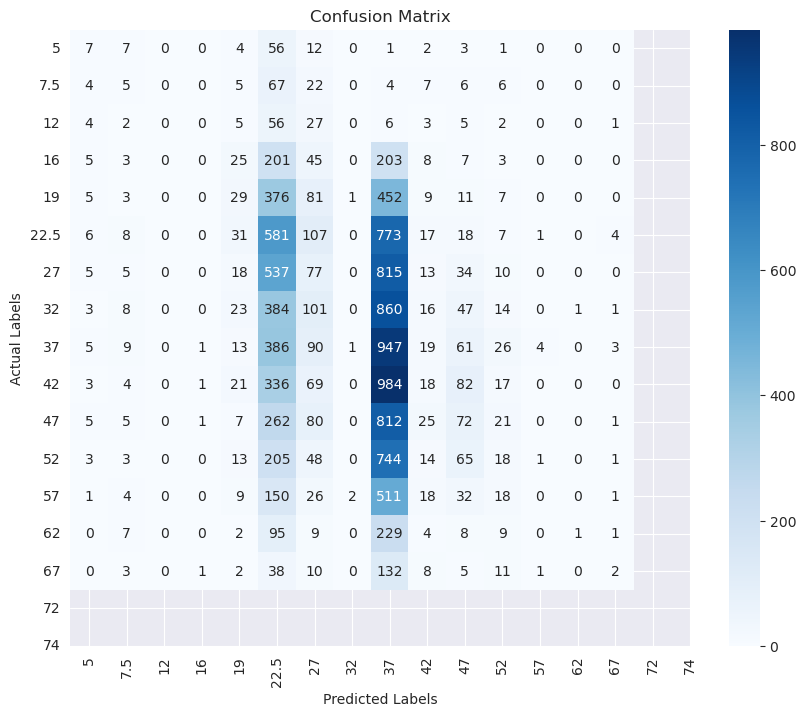

In [217]:
cm = confusion_matrix(y_val_true, y_val_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')

# Adding tick labels for better readability
classes = [5, 7.5, 12, 16, 19, 22.5, 27, 32, 37, 42, 47, 52, 57, 62, 67, 72, 74]  # Replace with your actual class names
plt.xticks(ticks=np.arange(len(classes)) + 0.5, labels=classes, rotation=90)
plt.yticks(ticks=np.arange(len(classes)) + 0.5, labels=classes, rotation=0)

plt.show()
